<a href="https://colab.research.google.com/github/zyang63/SDAS-/blob/main/SDAS_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from skimage import filters, morphology, measure, segmentation, exposure
from scipy import fftpack
import os
import tifffile as tiff
import csv
import matplotlib.pyplot as plt

In [ ]:
def preprocess_binary_image(image_path):
  InputImage = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  if len(InputImage.shape) == 3:
    InputImage = cv2.cvtColor(InputImage, cv2.COLOR_BGR2GRAY)
    InputImage = 255 - InputImage
  InputImage = (InputImage > 0).astype(np.uint8)
  return InputImage

In [ ]:
def preprocess_image(image_path, morphologicalSize, holesize, hpfilt):
    InputImage = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if len(InputImage.shape) == 3:
        InputImage = cv2.cvtColor(InputImage, cv2.COLOR_BGR2GRAY)
        InputImage = 255 - InputImage
        level = filters.threshold_multiotsu(InputImage, classes=3)
        PorosityMask = InputImage > level[1]
        PorosityMask = PorosityMask & ~segmentation.clear_border(PorosityMask)
        InputImage[~PorosityMask] = exposure.adjust_sigmoid(InputImage[~PorosityMask])
        InputImage = InputImage * (~PorosityMask).astype(np.uint8)
        fftI = fftpack.fftshift(fftpack.fft2(InputImage))
        x, y = np.meshgrid(np.arange(InputImage.shape[1]), np.arange(InputImage.shape[0]))
        MASK = np.sqrt((x - InputImage.shape[0] // 2)**2 + (y - InputImage.shape[1] // 2)**2) > hpfilt
        InputImage = np.real(fftpack.ifft2(fftpack.ifftshift(fftI * MASK)))
    else:
        InputImage = exposure.adjust_sigmoid(InputImage)
    T = filters.threshold_local(InputImage, block_size=2 * (InputImage.shape[0] // 16 + 1) + 1, method="gaussian")
    InputImage = (InputImage > T).astype(np.uint8)
    InputImage = morphology.closing(cv2.medianBlur(InputImage, 3 * morphologicalSize), morphology.disk(morphologicalSize))
    InputImage = morphology.remove_small_holes(morphology.remove_small_objects(InputImage, holesize), holesize)
    del T, MASK, x, y, fftI, PorosityMask, level
    return InputImage.astype(np.uint8)

In [ ]:
def process_image(InputImage, numberCross, angleIncrement):
    y, x = InputImage.shape[:2]
    diagonal = int(np.ceil(np.sqrt(y**2 + x**2))+2)
    AngleStraight = np.zeros((y, x))
    ImapMinSpacing = np.full((y, x), np.inf, dtype=np.float32)
    for angleRotate in np.arange(0, 180, angleIncrement).astype(np.float32):
        ImapSpacing = np.ones((diagonal, diagonal), dtype=InputImage.dtype)
        ImapSpacing[(diagonal - y) // 2:(diagonal - y) // 2+y, (diagonal - x) // 2:(diagonal - x) // 2+x] = 1-InputImage
        ImapSpacing = cv2.warpAffine(ImapSpacing, cv2.getRotationMatrix2D((diagonal // 2, diagonal // 2), angleRotate, 1), (diagonal, diagonal))
        ImapSpacing[:, 1:] -= ImapSpacing[:, :-1]
        ImapSpacing = np.abs(ImapSpacing)
        np.cumsum(ImapSpacing == 1, axis=1, out=ImapSpacing)
        maxLabels = ImapSpacing.max(axis=1)
        max_label = np.max(ImapSpacing)
        label_counts = np.sum(ImapSpacing[:, :, None] == np.arange(max_label+1)[None, None, :], axis=1)
        centroids = np.roll(np.cumsum(label_counts, axis=1), shift=1, axis=1).astype(np.float32)
        centroids[:, 0] = 0
        centroids += 0.5 * label_counts
        ImapSpacing = np.maximum(1, np.minimum(maxLabels[:, None] - numberCross, np.fix(ImapSpacing - numberCross/2)))
        ImapSpacing = centroids[np.indices(ImapSpacing.shape)[0], (ImapSpacing + numberCross - 2).astype(int)] - centroids[np.indices(ImapSpacing.shape)[0], ImapSpacing.astype(int)]
        ImapSpacing *= 2. / numberCross
        ImapSpacing = cv2.warpAffine(ImapSpacing, cv2.getRotationMatrix2D((diagonal // 2, diagonal // 2), -angleRotate, 1), (diagonal, diagonal), borderValue=np.inf)
        ImapSpacing[np.isnan(ImapSpacing)] = np.inf
        np.minimum(ImapMinSpacing, ImapSpacing[(diagonal - y) // 2:(diagonal - y) // 2+y, (diagonal - x) // 2:(diagonal - x) // 2+x], out=ImapMinSpacing)
        AngleStraight[np.logical_and(ImapMinSpacing == ImapSpacing[(diagonal - y) // 2:(diagonal - y) // 2+y, (diagonal - x) // 2:(diagonal - x) // 2+x], ImapMinSpacing != np.inf)] = angleRotate
    return ImapMinSpacing, AngleStraight

In [ ]:
def process_images(OutputFolder, ImapMinSpacing, AngleStraight, InputImage, numberCross, hpfilt, angleIncrement, morphologicalSize, holesize, ImageName):
    if not os.path.exists(OutputFolder):
        os.makedirs(OutputFolder)
    base_format = f"_numberCross{numberCross}_hp{hpfilt}ang{angleIncrement}mph{morphologicalSize}hz{holesize}{ImageName}"
    SpacingFileName = os.path.join(OutputFolder, "Spacing"+base_format)
    tiff.imwrite(SpacingFileName, ImapMinSpacing.astype(np.float32))
    AngleFileName = os.path.join(OutputFolder, "ANGLE"+base_format)
    tiff.imwrite(AngleFileName, AngleStraight.astype(np.float32))
    SegmentationFilename = os.path.join(OutputFolder, "SEGMENTATION"+base_format)
    tiff.imwrite(SegmentationFilename, InputImage.astype(np.uint8))
    Quartiles = np.quantile(ImapMinSpacing, [0.25, 0.50, 0.75])
    outputCSV = os.path.join(OutputFolder, 'output.csv')
    headers = ['InputImage', 'meanSpacing', 'stdDevSpacing', 'meanAngle', 'stdAngle', 'crossings', 'angleIncrement', 'mph', 'holesize', 'numberOfMeasurements', 'LowerQuartile', 'Median', 'UpperQuartile']
    row = [ImageName, np.mean(ImapMinSpacing), np.std(ImapMinSpacing), np.mean(AngleStraight), np.std(AngleStraight), numberCross, angleIncrement, morphologicalSize, holesize, np.sum(~np.isnan(ImapMinSpacing)), Quartiles[0], Quartiles[1], Quartiles[2]]
    if not os.path.exists(outputCSV):
        with open(outputCSV, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(headers)
            writer.writerow(row)
    else:
        with open(outputCSV, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(row)

In [ ]:
hpfilt = 5
morphologicalSize=3
holesize=150
#filename = '1000x_1.tif'
filename = '3_test.tif'
outputfolder = 'newoutput'
#binary = preprocess_image('/content/'+filename, morphologicalSize, holesize, hpfilt)
binary = preprocess_binary_image('/content/'+filename)

In [ ]:
numberCross = 13
angleIncrement = np.arctan(1/39) * (180/np.pi)
ImapMinSpacing, AngleStraight = process_image(binary, numberCross, angleIncrement)
process_images('/content/'+outputfolder, ImapMinSpacing, AngleStraight, binary, numberCross, hpfilt, angleIncrement, morphologicalSize, holesize, filename)

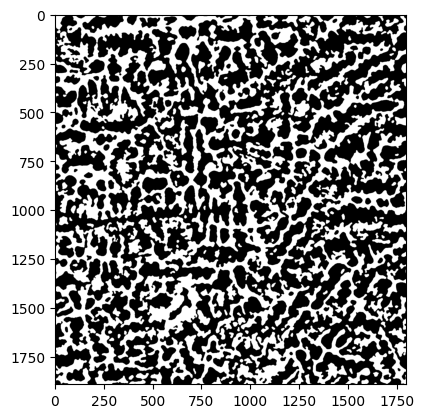

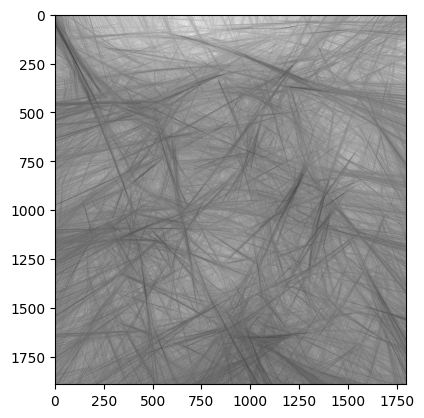

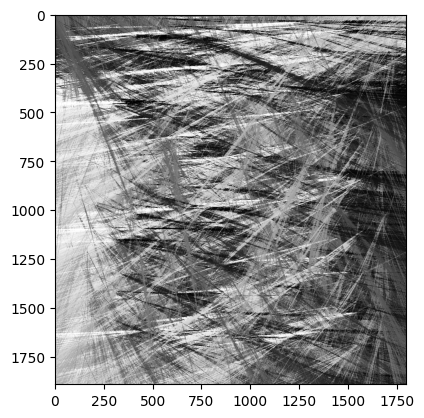

In [ ]:
plt.imshow(binary, cmap='gray')
plt.show()
plt.imshow(ImapMinSpacing, cmap='gray')
plt.show()
plt.imshow(AngleStraight, cmap='gray')
plt.show()